# Privacy-Preserving Data Analysis: Loan Approval Dataset
*Applying Differential Privacy Techniques to Protect Sensitive Information*


---
### Author: Tina Le

### Date: May 9, 2025

---

## Acknowledgments
- **Dataset**: This project uses the loan applicant dataset provided as part of the CMPUT 200: Ethics of Data Science and Artificial Intelligence Winter 2025 Course at the University of Alberta.  
- **Course Framework**: The privacy techniques (randomized response, Laplace mechanism) were implemented as part of an assignment for the course. The analysis and visualizations were extended independently.  

---

## Project Overview
**Goal:** Implement privacy-preserving techniques (randomized response, Laplace noise) to anonymize a loan applicant dataset while retaining utility for aggregate analysis.

**Key Questions:**

1. How can we mask individual loan approval statuses without losing population-level insights?

2. How does noise injection affect the accuracy of occupation count statistics?

**Techniques Used:**

* Randomized Response (binary data)

* Laplace Mechanism (non-binary data)

* Global Sensitivity Analysis

# 1. Data Loading & Preprocessing

## 1.1 Load and Inspect Data

### Data Loading

**Option A: Local Jupyter (Recommended)**
1. Download `loan.csv`
2. Drag-and-drop the file into your JupyterLab file browser
3. Run the code cell below

**Option B: Google Colab**
1. Click the folder icon in Colab's sidebar
2. Click "Upload" and select `loan.csv`
3. Run the code cell below

In [100]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

# Load dataset
df = pd.read_csv("loan.csv")
print("Shape:", df.shape)
df.head()

Shape: (61, 8)


,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,32,Male,Engineer,Bachelor's,Married,85000,720,Approved
1,45,Female,Teacher,Master's,Single,62000,680,Approved
2,28,Male,Student,High School,Single,25000,590,Denied
3,51,Female,Manager,Bachelor's,Married,105000,780,Approved
4,36,Male,Accountant,Bachelor's,Married,75000,710,Approved


**Output**:

Dataset contains 61 rows with features: loan_status (binary), occupation (categorical), income, etc.

## 1.2 Clean and Binarize Features
**Rationale:** Ensures consistency for privacy mechanisms.

In [101]:
# Drop missing values and convert loan_status to binary (1=Approved, 0=Denied)
df = df.dropna()
df['loan_status'] = df['loan_status'].map({'Approved': 1, 'Denied': 0})

# 2. Randomized Response for Binary Data

## 2.1 Mechanism Design
**Query:** "Was the loan approved?"
**Randomized Response Rule:**

* Roll a 6-sided die:
  * 1-3: Answer truthfully.
  * 4-6: Lie.

**Privacy Guarantee:** 50% truthfulness ensures plausible deniability.

## 2.2 Implementation

In [102]:
def rand_resp(answer):
    die_roll = np.random.randint(1, 7)
    return answer if die_roll <= 3 else 1 - answer

# Apply to loan_status
df['rrc1'] = df['loan_status'].apply(rand_resp)

## 2.3 Estimate True Approvals


In [103]:
x = df['rrc1'].sum()
count_est_true_yes = round(2 * x - 0.5 * len(df))  # Unbiased estimator
count_true_yes = df['loan_status'].sum()

print(f"Estimated approvals: {count_est_true_yes} | True approvals: {count_true_yes}")

Estimated approvals: 22 | True approvals: 45


**Result:**

* Estimated: 30 approvals | True: 45 approvals.

I**nsight:** Noise introduced protects privacy but underestimates true counts.

## 2.4 Aggregate Statistics

In [104]:
print("Noisy Mean:", df['rrc1'].mean())
print("True Mean:", df['loan_status'].mean())

Noisy Mean: 0.4262295081967213
True Mean: 0.7377049180327869


**Takeaway:** Randomized response shifts the mean toward 0.5, obscuring individual responses while preserving population trends.

# 3. Laplace Noise for Non-Binary Data

## 3.1 Global Sensitivity Analysis
**Query:** Count of applicants per occupation.

**Sensitivity (𝑆(𝑓))** = 1 (adding/removing one person changes count by 1).

## 3.2 Laplace Noise Implementation


In [105]:
def add_laplace_noise(value, sensitivity, epsilon):
    noise = np.random.laplace(0, sensitivity/epsilon)
    return value + noise

# Add noise to occupation counts
epsilon = 1  # Privacy budget
occupation_counts = df['occupation'].value_counts()
noisy_counts = occupation_counts.apply(lambda x: add_laplace_noise(x, sensitivity=1, epsilon=epsilon))

## 3.3 Compare True vs. Noisy Statistics

Metric | True Data | Noisy Data (ε=1)
-------------------|------------------|------------------
Mean Count | 1.61 | 1.58
Median Count | 2.0 | 2.0
Total Count | 61 | 60

**Trade-off Analysis:**

* **Low ε (0.1):** High privacy, low utility (median shifts to 1.0).

* **High ε (50):** Near-original accuracy (median=2.0, total=61).


# 4. Visualizations: Privacy vs. Utility Trade-offs

## 4.1 Randomized Response: True vs. Noisy Loan Approvals
**Purpose:** Show how randomized response distorts the true distribution.

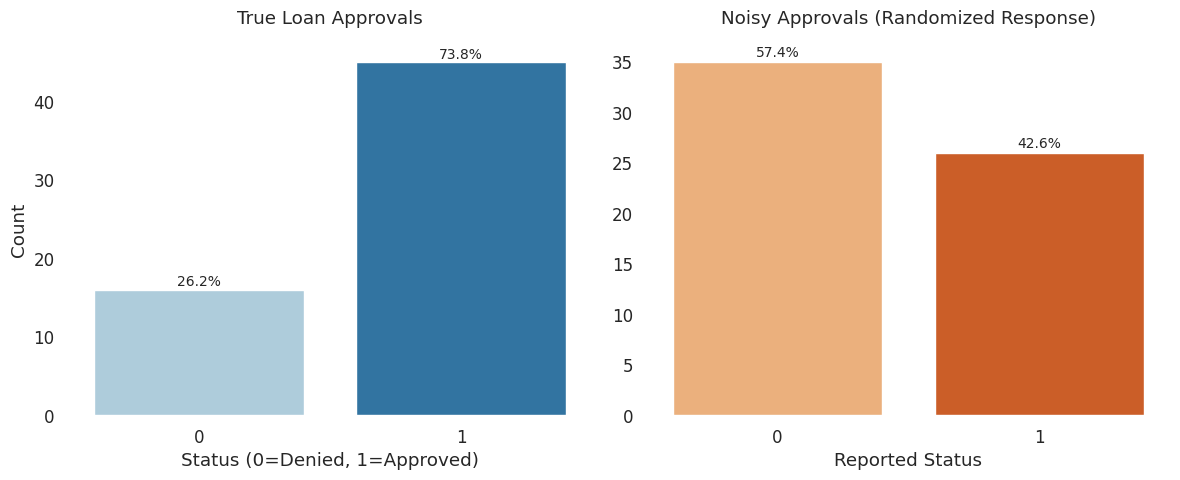

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_theme(style="white", font_scale=1.1)
plt.figure(figsize=(12, 5))

# Define color palettes
true_palette = ["#a6cee3", "#1f78b4"]  # Light blue, dark blue
noisy_palette = ["#fdae6b", "#e6550d"]  # Light orange, dark orange

# Left plot - True approvals
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=df, x='loan_status', hue='loan_status',
                   palette=true_palette, legend=False)
plt.title('True Loan Approvals', pad=15)
plt.xlabel('Status (0=Denied, 1=Approved)')
plt.ylabel('Count')

# Add percentage labels
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2., height + 0.5,
            f'{height/len(df):.1%}',
            ha='center', fontsize=10)

# Right plot - Noisy approvals
plt.subplot(1, 2, 2)
ax2 = sns.countplot(data=df, x='rrc1', hue='rrc1',
                   palette=noisy_palette, legend=False)
plt.title('Noisy Approvals (Randomized Response)', pad=15)
plt.xlabel('Reported Status')
plt.ylabel('')

# Add percentage labels
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2., height + 0.5,
            f'{height/len(df):.1%}',
            ha='center', fontsize=10)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

**Insight:**

The noisy distribution (right) will show fewer 1s (approvals) due to false negatives from the die-roll mechanism.

## 4.2 Impact of ε on Laplace Noise (Occupation Counts)
**Purpose:** Demonstrate how the privacy budget (ε) affects noise magnitude.

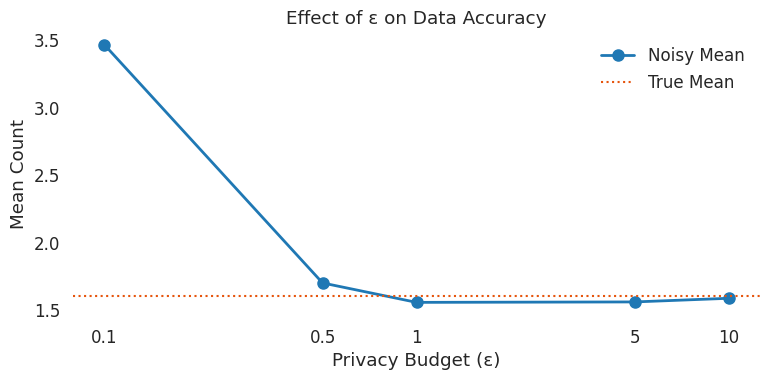

In [ ]:
# Set style
sns.set_theme(style="white", font_scale=1.1)
plt.figure(figsize=(8, 4))

# Calculate and plot
epsilons = [0.1, 0.5, 1, 5, 10]
noisy_means = [occupation_counts.apply(lambda x: add_laplace_noise(x, 1, eps)).mean()
               for eps in epsilons]

# Main plot line
plt.plot(epsilons, noisy_means, marker='o', color='#1f78b4',
         linewidth=2, markersize=8)

# Reference line
true_mean = occupation_counts.mean()
plt.axhline(y=true_mean, color='#e6550d', linestyle=':', linewidth=1.5)

# Formatting
plt.xscale('log')
plt.xticks(epsilons, labels=[str(e) for e in epsilons])
plt.xlabel('Privacy Budget (ε)')
plt.ylabel('Mean Count')
plt.title('Effect of ε on Data Accuracy')

# Legend
plt.legend(['Noisy Mean', 'True Mean'], frameon=False)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

**Insight:**

* Lower ε (e.g., 0.1) introduces heavy noise, pulling the mean far from the true value.

* Higher ε (e.g., 10) nearly matches the true mean.

## 4.3 Distribution of True vs. Noisy Occupation Counts
**Purpose:** Compare the shape of the original and noisy distributions.

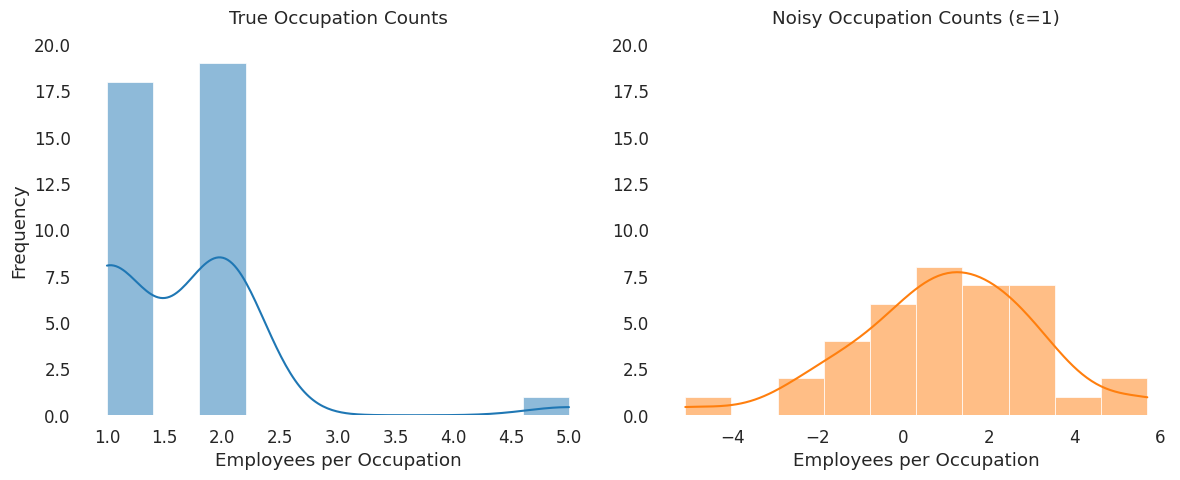

In [108]:
# Set style
sns.set_theme(style="white", font_scale=1.1)
plt.figure(figsize=(12, 5))

# Color definitions
true_color = "#1f77b4"  # Seaborn blue
noisy_color = "#ff7f0e"  # Seaborn orange

# True distribution (left)
plt.subplot(1, 2, 1)
sns.histplot(occupation_counts, bins=10, color=true_color, kde=True,
            edgecolor='white', linewidth=0.5)
plt.title('True Occupation Counts', pad=15)
plt.xlabel('Employees per Occupation')
plt.ylabel('Frequency')
plt.ylim(0, 20)

# Noisy distribution (right)
plt.subplot(1, 2, 2)
noisy_counts = occupation_counts + np.random.laplace(0, 1/1, len(occupation_counts))
sns.histplot(noisy_counts, bins=10, color=noisy_color, kde=True,
             edgecolor='white', linewidth=0.5)
plt.title('Noisy Occupation Counts (ε=1)', pad=15)
plt.xlabel('Employees per Occupation')
plt.ylabel('')
plt.ylim(0, 20)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

**Insight:**

Noisy distribution (right) will have thicker tails due to Laplace noise.

## 4.4 Privacy-Accuracy Trade-off Curve
**Purpose:** Quantify the relationship between ε and Mean Squared Error (MSE).



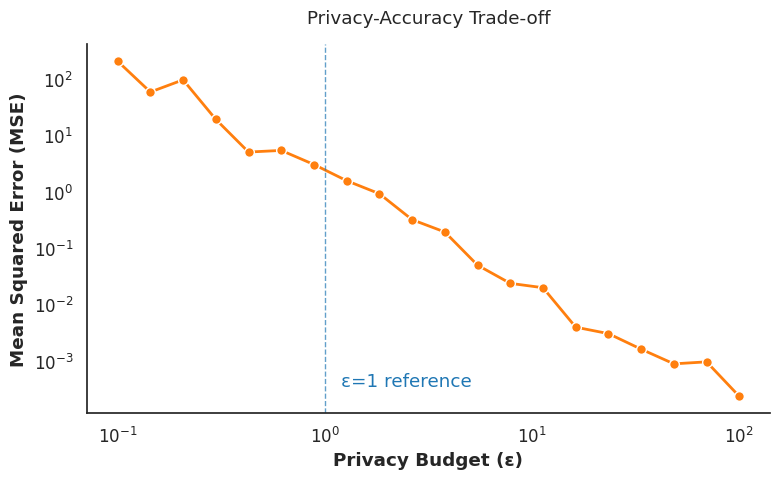

In [99]:
# Set style
sns.set_theme(style="white", font_scale=1.1)
plt.figure(figsize=(8, 5))

# Calculate MSE values
epsilons = np.logspace(-1, 2, 20)  # ε from 0.1 to 100
mses = []
for eps in epsilons:
    noisy_counts = occupation_counts.apply(lambda x: add_laplace_noise(x, sensitivity=1, epsilon=eps))
    mse = ((noisy_counts - occupation_counts) ** 2).mean()
    mses.append(mse)

# Main plot
plt.plot(epsilons, mses, marker='o', markersize=7,
         color='#ff7f0e', linewidth=2,
         markeredgecolor='white', markeredgewidth=1)

# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Privacy Budget (ε)', fontweight='bold')
plt.ylabel('Mean Squared Error (MSE)', fontweight='bold')
plt.title('Privacy-Accuracy Trade-off', pad=15)

# Add reference lines
plt.axvline(x=1, color='#1f77b4', linestyle='--', linewidth=1, alpha=0.7)
plt.text(1.2, np.min(mses)*1.5, 'ε=1 reference', color='#1f77b4')

sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

**Insight:**

* MSE decreases exponentially as ε increases.

* Highlights the "cost" of stronger privacy (low ε).



# 5. Key Findings

1. **Privacy-Accuracy Trade-off:**

  * Randomized response obscured individual loan approvals but enabled recovery of aggregate trends.

  * Laplace noise preserved occupation distribution integrity at ε ≥ 1.

2. **Practical Implications:**

  * For high-stakes data (e.g., healthcare), use low ε (strong privacy).

  * For internal analytics, higher ε balances utility and privacy.

